

<div class="alert alert-block alert-info" style="width:400px, text-color:black"> 
For this task we will use  the <a href="https://www.kaggle.com/datasets/nipunarora8/age-gender-and-ethnicity-face-data-csv?select=age_gender.csv">age-gender-and-ethnicity-face dataset</a> which contains a number of images, each accompanied with features recording the age,  gender,  and ethnicity of the person in the image. This is a  version of the <a href="https://susanqq.github.io/UTKFace/" > UTKface dataset</a>, modified to make it easer to load as one file.<br>
Please note that
    <ul>
        <li>It happens not contain any people who self-identified as non-binary. So gender is labelled as 0 (male) or 1 (female)</li>
        <li> Ethicity is coded as an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern) (terms from original site).</li>
          <li>  Each row of this version of the dataset contains integer values for the three features, a string with the name or the original jpg from the UTK archive, and a feature called 'pixels' which contains the 48x48 pixels values as a string.</li>
    </ul>

After some preliminaries, the next two cells load the data into a pandas dataframe and then shpw the first ten lines.

In [1]:
import numpy as np 
import pandas as pd
import os
import socket
import random
from matplotlib import pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as keras_layers

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
tf.get_logger().setLevel('ERROR')


## Some constants to keep experiments the same

In [2]:
batchsize=50
max_epochs=100
num_imgs=500
patience=5

## Define useful method to plot training history and confusion matrix

In [3]:
def report(history,y_pred,y_true):
    plt.plot(history.epoch, history.history["accuracy"],history.history['val_accuracy'])
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.suptitle('Training (blue) and validation (orange) History')
    plt.show()
    
    predicted= np.argmax(y_pred,axis=1)
    actual = np.argmax(y_true,axis=1)
    print(f'Test Accuracy {(predicted==actual).sum() *100/len(actual)}%')
    cm=ConfusionMatrixDisplay.from_predictions(actual,predicted,display_labels=['male','female']) 


# Get the face data

In [4]:
if (socket.gethostname()=='csctcloud'): #on csctcloud
    path="/home/common/datasets/"
else: #machine specific- this is for jim's development
    path = "../datasets"
dataframe = pd.read_csv(path+'/utk/teacher_pupil.csv')
dataframe.head()

age  ethnicity  gender                        img_name  \
0    1          2       0  20161219203650636.jpg.chip.jpg   
1    1          2       0  20161219222752047.jpg.chip.jpg   
2    1          2       0  20161219222832191.jpg.chip.jpg   
3    1          2       0  20161220144911423.jpg.chip.jpg   
4    1          2       0  20161220144914327.jpg.chip.jpg   

                                              pixels  label  
0  129.0 128.0 128.0 126.0 127.0 130.0 133.0 135....  pupil  
1  164.0 74.0 111.0 168.0 169.0 171.0 175.0 182.0...  pupil  
2  67.0 70.0 71.0 70.0 69.0 67.0 70.0 79.0 90.0 1...  pupil  
3  193.0 197.0 198.0 200.0 199.0 200.0 202.0 203....  pupil  
4  202.0 205.0 209.0 210.0 209.0 209.0 210.0 211....  pupil

### Let's start by splitting the images into appropriate numpy arrays
- We first convert the 'pixels' column of the dataframe into a numpy array
- then split each row into a sub-array using a space as a seperator, 
- before reshaping our array from 23705x2304 floats into 23705 * (48x48) images
- the conversion of the labels is first makes a straightforward 1d array, 
  then uses that to put 1s into the right column of a 2d array for one-hot encoding 

In [5]:
imgs = dataframe['pixels'].to_numpy()
print(f'original shape of imgs array {imgs.shape}')
imgs = np.array([x.split(' ') for x in imgs], dtype=float)
print(f' shape  after splitting: {imgs.shape}')
imgs = imgs.reshape(-1,48,48,1).astype(int)
print(f'shape  after reshaping into 2d images with one channel: {imgs.shape}')

original shape of imgs array (23705,)
 shape  after splitting: (23705, 2304)
shape  after reshaping into 2d images with one channel: (23705, 48, 48, 1)


In [6]:
labels= dataframe['gender'].to_numpy()
y = to_categorical(labels,num_classes=2)
print(f'shape of labels is {labels.shape} and y is {y.shape}')
print(f'Split of males:females in the labels is {np.unique(labels,return_counts=True)[1]}')

shape of labels is (23705,) and y is (23705, 2)
Split of males:females in the labels is [12391 11314]


### This is what ten randomly chosen images look like

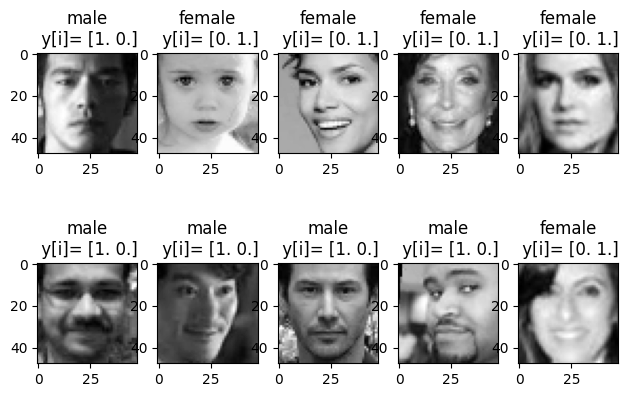

In [7]:
fig,axs=plt.subplots(2,5,figsize=(7.5,5))
for i in range(10):
    img = random.randint(0,labels.shape[0])
    axs[i//5][i%5].imshow(imgs[img],cmap='gray')
    axs[i//5][i%5].set_title(f'{ "male" if labels[img]==0 else "female"}\n y[i]= {y[img]}')
                                   

### Finally use standard sklearn function to split data into training and test set

In [8]:

X_train,X_test,y_train,y_test= train_test_split(imgs,y,test_size=7705,shuffle=True,stratify=y)
print(f'For sanity-checking: train and test arrays have shapes {X_train.shape}, {X_test.shape},{y_train.shape},{y_test.shape}')

For sanity-checking: train and test arrays have shapes (16000, 48, 48, 1), (7705, 48, 48, 1),(16000, 2),(7705, 2)


## Now the convnet bit
- start by specifying  a function to create a straightforward CNN using keras sequential model interface
- then make a model and train it

The architecture is inspired by [this kaggle post](https://www.kaggle.com/code/amishaasrani/gender-detection-by-cnn).  
It optionally introduces some new types of layer into each convolution-maxpooling block, which implement some standard tricks to improve deep networks training.
1. *Batch normalisation* is a method that attempts to reduce the random effects of dividing the data into batches.  
   It works by scaling the outputs from each batch of data so they lie roughly within constant bounds estimated as the mean of the training data +/- the std. deviation of the training data.  
   The net effect is usually to make it **faster to train** a network.  
   [keras documentation here](https://keras.io/api/layers/normalization_layers/batch_normalization/)  
   [Machine Learning Mastery blog here](https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/)
2. *Dropout* is a **regularisation** technique applied to try and reduce the number of variables (non-zero weights) in the learned model.  
   It works  by effectively pruning connections.  During training a fraction (0.2 in this case) of the nodes are arbitrarily 'switched off' for each batch,  so that the back-propagation can then reduce weight that do not seme to have any effect. 
   The net effect is usually **to help prevent over-fitting**. 
   [keras documentation here](https://keras.io/api/layers/regularization_layers/dropout/)  
   [Machine Learning Mastery blog here](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/)

In [10]:
def conv_model(num_classes,use_dropout=False,use_batch_norm=False):
    model = Sequential()
    
    #first block of layers
    model.add(keras_layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding = "same", input_shape=(48,48,1)))
    if use_batch_norm:
        model.add(keras_layers.BatchNormalization())
    model.add(keras_layers.MaxPool2D(pool_size=(2,2)))
    if use_dropout:
        model.add(keras_layers.Dropout(0.2))
    
    #second block of layers
    model.add(keras_layers.Conv2D(64, kernel_size=(3,3),activation="relu",padding="same"))
    if use_batch_norm:
        model.add(keras_layers.BatchNormalization())
    model.add(keras_layers.MaxPool2D(pool_size=(2,2)))
    if use_dropout:
        model.add(keras_layers.Dropout(0.2))
    
    #third block of layers
    model.add(keras_layers.Conv2D(64, kernel_size=(3,3),activation="relu",padding="same"))
    if use_batch_norm:
        model.add(keras_layers.BatchNormalization())
    model.add(keras_layers.MaxPool2D(pool_size=(2,2)))
    if use_dropout:
        model.add(keras_layers.Dropout(0.2))
    
    #fully connected layers followed by softmax output
    model.add(keras_layers.Flatten())
    model.add(keras_layers.Dense(256,activation="relu"))#256
    model.add(keras_layers.Dense(num_classes, activation="softmax"))
    
    model.compile(optimizer='Adam',
              loss= 'BinaryCrossentropy',
              metrics=['accuracy'])
    return model

In [11]:
convnet = conv_model(num_classes=2)
convnet.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxP

2023-02-16 08:45:25.635699: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-16 08:45:25.636018: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Train the model using an early stopping criteria

In [12]:
early_stopping = EarlyStopping(monitor='val_loss',patience=patience, 
                               min_delta=0.001,
                               restore_best_weights=True)


history= convnet.fit(X_train,y_train,validation_split=0.1,epochs=max_epochs,batch_size=batchsize, callbacks=early_stopping,verbose=True)

Epoch 1/100


2023-02-16 08:45:41.769203: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-16 08:45:41.948184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


283/288 [============================>.] - ETA: 0s - loss: 0.9681 - accuracy: 0.7113

2023-02-16 08:45:45.219488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


288/288 [==============================] - 4s 12ms/step - loss: 0.9589 - accuracy: 0.7128 - val_loss: 0.4450 - val_accuracy: 0.8131
Epoch 2/100
288/288 [==============================] - 3s 11ms/step - loss: 0.4114 - accuracy: 0.8109 - val_loss: 0.3537 - val_accuracy: 0.8462
Epoch 3/100
288/288 [==============================] - 3s 11ms/step - loss: 0.3599 - accuracy: 0.8404 - val_loss: 0.3257 - val_accuracy: 0.8519
Epoch 4/100
288/288 [==============================] - 3s 11ms/step - loss: 0.3370 - accuracy: 0.8501 - val_loss: 0.2953 - val_accuracy: 0.8687
Epoch 5/100
288/288 [==============================] - 3s 11ms/step - loss: 0.3136 - accuracy: 0.8619 - val_loss: 0.3035 - val_accuracy: 0.8656
Epoch 6/100
288/288 [==============================] - 3s 11ms/step - loss: 0.2907 - accuracy: 0.8749 - val_loss: 0.3034 - val_accuracy: 0.8669
Epoch 7/100
288/288 [==============================] - 3s 11ms/step - loss: 0.2743 - accuracy: 0.8793 - val_loss: 0.2783 - val_accuracy: 0.8675
Epoc

 54/241 [=====>........................] - ETA: 0s

2023-02-16 08:46:25.486787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


241/241 [==============================] - 1s 5ms/step


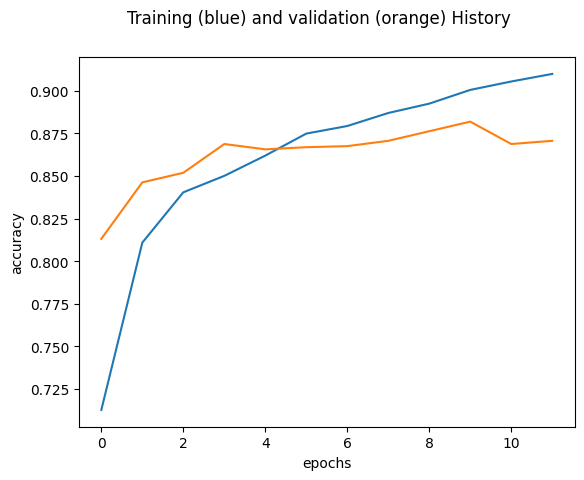

Test Accuracy 87.12524334847501%


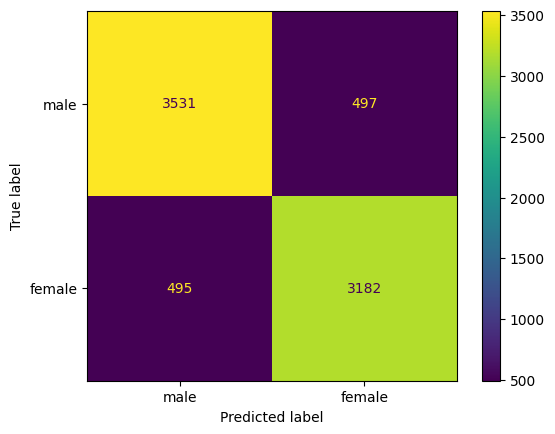

In [13]:
y_pred= convnet.predict(X_test)
y_true=y_test
report(history,y_pred,y_true)

## But what if we had fewer samples?

- say 500  in total
- and we use 20% for testing
- and 10% for validation  to do early stopping

We'll use the sklearn train_test_split() method to make sure the male/female mix in our subset is roughly the same as in our original data

In [14]:
num_imgs=500
seed = 12345
_, img_subset,_,label_subset= train_test_split(imgs,y,
                                               test_size=num_imgs,
                                               shuffle=True,stratify=y,
                                               random_state=seed)
X_train,X_test,y_train,y_test= train_test_split(img_subset,label_subset,
                                                test_size=0.2,
                                                shuffle=True,stratify=label_subset,
                                                random_state=seed)
print(f'gender split in training subset {np.unique(y_train[:,0].astype(int),return_counts=True)[1]}')
print(f'gender split in test subset {np.unique(y_test[:,0].astype(int),return_counts=True)[1]}')

gender split in training subset [191 209]
gender split in test subset [48 52]


### Retrain a new  model on this smaller dataset

In [15]:
convnet2 = conv_model(num_classes=2)
history= convnet2.fit(X_train,y_train,validation_split=0.125,epochs=max_epochs,batch_size=batchsize, callbacks=early_stopping,verbose=True)
y_pred= convnet2.predict(X_test)

Epoch 1/100
1/7 [===>..........................] - ETA: 1s - loss: 5.5141 - accuracy: 0.4600

2023-02-16 08:47:24.565381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 1s 38ms/step - loss: 14.2019 - accuracy: 0.5400 - val_loss: 1.3972 - val_accuracy: 0.4400
Epoch 2/100
7/7 [==============================] - 0s 14ms/step - loss: 0.9379 - accuracy: 0.5714 - val_loss: 0.5772 - val_accuracy: 0.7000
Epoch 3/100


2023-02-16 08:47:24.868596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 14ms/step - loss: 0.6359 - accuracy: 0.6486 - val_loss: 0.6542 - val_accuracy: 0.5800
Epoch 4/100
7/7 [==============================] - 0s 14ms/step - loss: 0.6067 - accuracy: 0.7029 - val_loss: 0.6408 - val_accuracy: 0.6000
Epoch 5/100
7/7 [==============================] - 0s 16ms/step - loss: 0.5733 - accuracy: 0.6971 - val_loss: 0.5876 - val_accuracy: 0.6200
Epoch 6/100
7/7 [==============================] - 0s 16ms/step - loss: 0.5700 - accuracy: 0.7086 - val_loss: 0.5922 - val_accuracy: 0.6400
Epoch 7/100
1/4 [======>.......................] - ETA: 0s

2023-02-16 08:47:25.626412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 84ms/step


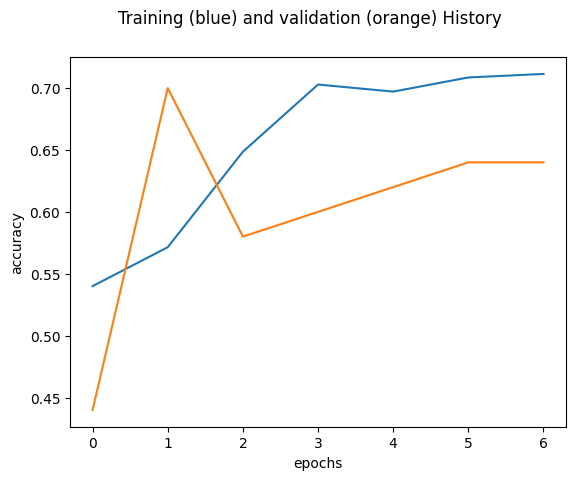

Test Accuracy 64.0%


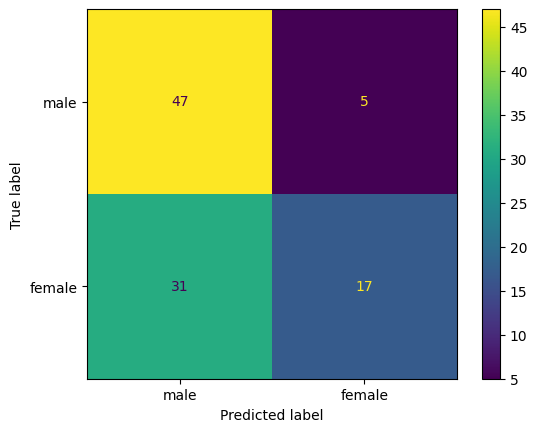

In [16]:
report(history,y_pred,y_test)

### so that's about a twenty percent hit in mean accuracy, and the accuracy for females is affected most

### Note also that early stopping kicks in around 14 epochs, 
- but accuracy is starting to flatline
- in my experiments it  changing patience to 10 only ran for ~5 more epochs and did not affect accuracy 

## Keras Support for data augmentation
There is a list of preprocessing layers, including data augmentation, and different ways of using them in a workflow in [this Keras guide](https://keras.io/guides/preprocessing_layers/).

For now we will begin by illustrating the effects of some common functions

In [17]:
data_augmentation = [Sequential(keras_layers.RandomFlip(mode='horizontal')),
                     Sequential(keras_layers.RandomContrast(1)), 
                     Sequential(keras_layers.RandomRotation(0.05)),
                     Sequential(keras_layers.RandomZoom(0.5)),
                     Sequential(keras_layers.RandomTranslation(0.1,0.1))]
names=['flip','contrast','rotation','zoom','translate']


2023-02-16 08:48:25.755819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-16 08:48:25.961028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-16 08:48:26.164205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-16 08:48:26.367156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-16 08:48:26.570339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-16 08:48:26.923607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-16 08:48:27.189842: I tensorflow/core/grappler/optimizers/cust

(-0.5, 47.5, 47.5, -0.5)

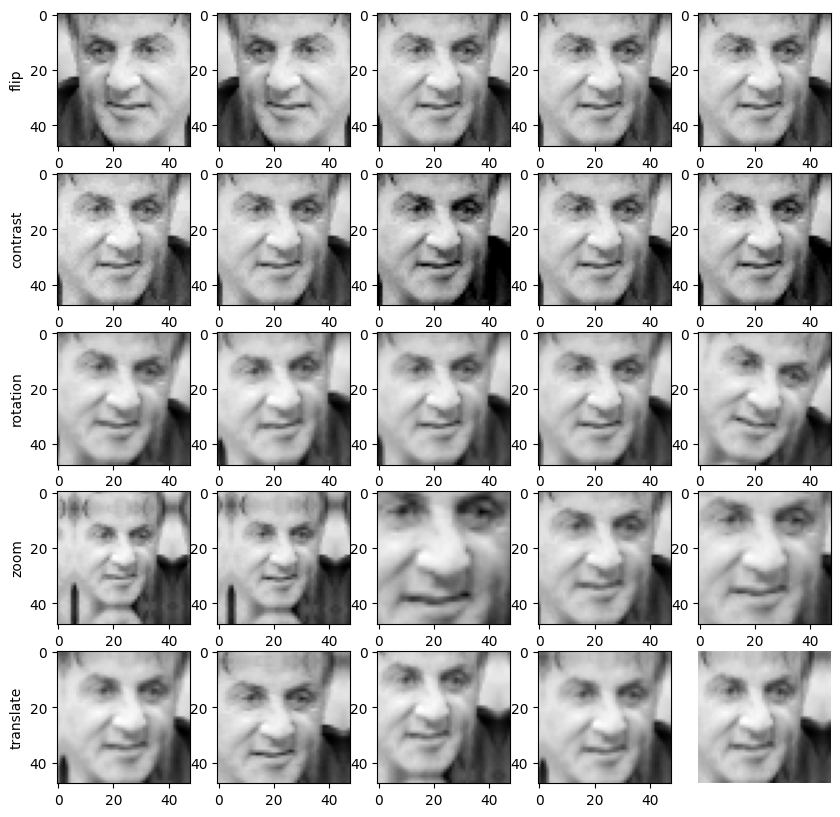

In [18]:
fig,axs= plt.subplots(len(names),5,figsize=(10, 10))
first_image = X_train[0]
for row in range(len(names)):
    axs[row][0].set_ylabel(names[row])
    for col in range(5):
        augmented_image = data_augmentation[row](
        tf.expand_dims(first_image, 0), training=True
        )
        axs[row][col].imshow(augmented_image[0].numpy().astype("int32"),cmap='gray')
plt.axis("off")

# so now to create a pipeline that will be used in training

In [19]:
def get_gender_face_data(seed=12345,num_imgs=1000):
    if (socket.gethostname()=='csctcloud'): 
        path="/home/common/datasets/"
    else: #machine specific
        path = "../datasets"
    dataframe = pd.read_csv(path+'/utk/teacher_pupil.csv')
    
    imgs = dataframe['pixels'].to_numpy()
    imgs = np.array([x.split(' ') for x in imgs], dtype=float)
    imgs = imgs.reshape(-1,48,48,1).astype(int)
    labels= dataframe['gender'].to_numpy()
    y = to_categorical(labels,num_classes=2)
    
    _, img_subset,_,label_subset= train_test_split(imgs,y,
                                                   test_size=num_imgs,
                                                   shuffle=True,
                                                   stratify=y,
                                                   random_state=seed)
    X_train,X_test,y_train,y_test= train_test_split(img_subset,label_subset,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=label_subset,
                                                    random_state=seed)
    print(f'gender split in training subset {np.unique(y_train[:,0].astype(int),return_counts=True)[1]}')
    print(f'gender split in test subset {np.unique(y_test[:,0].astype(int),return_counts=True)[1]}')

    return X_train,X_test,y_train,y_test

In [20]:
# make a function that will let us choose which augementations to use
def make_augmenter(flip=True,contrast=True,rotation=True,zoom=True,translation=True):
    augmenter = Sequential()
    #add 'do-nothing' layer in case rest are all false
    augmenter.add(keras_layers.Lambda(lambda x: x))
    #
    if flip:
        print('adding random flip')
        augmenter.add(keras_layers.RandomFlip(mode='horizontal'))
    if contrast:
        print('adding random contrast')
        augmenter.add(keras_layers.RandomContrast(1))
    if rotation:
        print('adding random rotation')
        augmenter.add(keras_layers.RandomRotation(0.05))
    if zoom:
        print('adding random zoom')
        augmenter.add(keras_layers.RandomZoom(0.5))
    if translation:
        print('adding random translation')
        augmenter.add(keras_layers.RandomTranslation(0.1,0.1))
    return augmenter

In [21]:
# Create a tf.data pipeline of augmented images (and their labels)
#this time we have to take out the validation set manually

def get_augmented_data_streams(X_train,y_train,batchsize,data_augmentation,valsplit=0.1):
    split=int(X_train.shape[0] * (1.0-valsplit))
    valsize= int(X_train.shape[0]*valsplit)
    assert  split+valsize ==len(y_train),f"can't split data we don't have {len(y_train)}"
    x_tr= X_train[:split,:]
    y_tr=y_train[:split]
    x_val= X_train[split:split+valsize,:]
    y_val=y_train[split:split+valsize]
    assert split%batchsize==0,f"training set size {split} must be multiple of batchsize{batchsize}"
    assert valsize%batchsize==0,"validation set size must be multiple of batchsize"

    #this is traigthforward
    validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    validation_dataset = validation_dataset.batch(batchsize)

    #trainig datraset gets augmented
    train_dataset = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
    train_dataset=train_dataset.shuffle(1000)
    train_dataset=train_dataset.batch(batchsize)
    train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x,training=True), y))
    
    return train_dataset,validation_dataset

### Now put all the pieces together into a function that can be called in a loop 
Note the only difference is that you might want to increase the patience 
- because we are using different training data each epoch
- so that naturally creates more variability

In [26]:
def run_experiment (flip=False,contrast=False,rotation=False,zoom=False,translation=False,batchsize=50,num_imgs=num_imgs,valsplit=0.125,patience=10):
    
    X_train,X_test,y_train,y_test = get_gender_face_data(num_imgs=num_imgs)
    data_augmentation= make_augmenter(flip=flip,contrast=contrast,rotation=rotation,zoom=zoom,translation=translation)
    train_dataset,val_dataset = get_augmented_data_streams(X_train,y_train, batchsize,data_augmentation,valsplit=valsplit)
    
    num_train_samples= int(X_train.shape[0] * (1.0-valsplit))
    print(f'Data made with {num_train_samples} training examples')
    
    augmented_cnn = conv_model(num_classes=2)
    early_stopping = EarlyStopping(monitor='val_loss',patience=patience, 
                               min_delta=0.001,
                               mode='min',
                               restore_best_weights=True)
    history= augmented_cnn.fit(train_dataset,
                               steps_per_epoch=num_train_samples/batchsize,
                               epochs=max_epochs,
                               batch_size=batchsize,
                               validation_data=val_dataset, 
                               callbacks=early_stopping,
                               verbose=True)

    y_pred = augmented_cnn.predict(X_test,verbose=0)
    return history, y_pred,y_test
    

In [27]:
#this runs an experiment
#with nothing set to be true this is just a replication of the original convnet training
history,y_pred,y_true= run_experiment(translation=False,
                                      rotation=True,
                                      flip=True,
                                      contrast=False,
                                      zoom=False,
                                      num_imgs=num_imgs,
                                      batchsize=batchsize,
                                      patience=20)


gender split in training subset [191 209]
gender split in test subset [48 52]
adding random flip
adding random rotation
Data made with 350 training examples
Epoch 1/100


2023-02-16 08:51:53.713864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-16 08:51:53.801630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-16 08:51:54.029592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 1s 70ms/step - loss: 13.6356 - accuracy: 0.4857 - val_loss: 0.9876 - val_accuracy: 0.3600
Epoch 2/100


2023-02-16 08:51:54.604336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-16 08:51:54.706911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 52ms/step - loss: 0.8015 - accuracy: 0.5286 - val_loss: 0.6290 - val_accuracy: 0.6600
Epoch 3/100
1/7 [===>..........................] - ETA: 0s - loss: 0.6488 - accuracy: 0.6400

2023-02-16 08:51:55.188402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 49ms/step - loss: 0.6644 - accuracy: 0.6286 - val_loss: 0.5599 - val_accuracy: 0.7600
Epoch 4/100
1/7 [===>..........................] - ETA: 0s - loss: 0.6492 - accuracy: 0.5600

2023-02-16 08:51:55.647673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 55ms/step - loss: 0.6234 - accuracy: 0.6400 - val_loss: 0.5404 - val_accuracy: 0.7000
Epoch 5/100
1/7 [===>..........................] - ETA: 0s - loss: 0.6452 - accuracy: 0.6000

2023-02-16 08:51:56.150356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 50ms/step - loss: 0.6137 - accuracy: 0.6486 - val_loss: 0.6865 - val_accuracy: 0.5600
Epoch 6/100
1/7 [===>..........................] - ETA: 0s - loss: 0.6311 - accuracy: 0.6800

2023-02-16 08:51:56.618909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 56ms/step - loss: 0.6002 - accuracy: 0.6829 - val_loss: 0.5728 - val_accuracy: 0.6800
Epoch 7/100
1/7 [===>..........................] - ETA: 0s - loss: 0.5343 - accuracy: 0.7600

2023-02-16 08:51:57.123225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 55ms/step - loss: 0.6001 - accuracy: 0.6714 - val_loss: 0.5521 - val_accuracy: 0.7200
Epoch 8/100
2/7 [=======>......................] - ETA: 0s - loss: 0.5683 - accuracy: 0.7200

2023-02-16 08:51:57.624041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 51ms/step - loss: 0.5698 - accuracy: 0.7343 - val_loss: 0.6060 - val_accuracy: 0.6400
Epoch 9/100
1/7 [===>..........................] - ETA: 0s - loss: 0.6142 - accuracy: 0.7200

2023-02-16 08:51:58.089886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 57ms/step - loss: 0.5539 - accuracy: 0.7114 - val_loss: 0.5456 - val_accuracy: 0.7200
Epoch 10/100
1/7 [===>..........................] - ETA: 0s - loss: 0.5135 - accuracy: 0.7600

2023-02-16 08:51:58.602000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 51ms/step - loss: 0.5308 - accuracy: 0.7400 - val_loss: 0.4677 - val_accuracy: 0.7600
Epoch 11/100
1/7 [===>..........................] - ETA: 0s - loss: 0.3695 - accuracy: 0.8600

2023-02-16 08:51:59.084454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 55ms/step - loss: 0.5044 - accuracy: 0.7400 - val_loss: 0.4827 - val_accuracy: 0.7800
Epoch 12/100
1/7 [===>..........................] - ETA: 0s - loss: 0.4335 - accuracy: 0.7800

2023-02-16 08:51:59.581025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 56ms/step - loss: 0.4894 - accuracy: 0.7429 - val_loss: 0.4959 - val_accuracy: 0.7200
Epoch 13/100
2/7 [=======>......................] - ETA: 0s - loss: 0.4219 - accuracy: 0.7900

2023-02-16 08:52:00.088654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 52ms/step - loss: 0.4583 - accuracy: 0.7771 - val_loss: 0.4722 - val_accuracy: 0.7600
Epoch 14/100
1/7 [===>..........................] - ETA: 0s - loss: 0.4776 - accuracy: 0.7800

2023-02-16 08:52:00.563250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 55ms/step - loss: 0.4781 - accuracy: 0.7571 - val_loss: 0.4974 - val_accuracy: 0.8000
Epoch 15/100
1/7 [===>..........................] - ETA: 0s - loss: 0.4714 - accuracy: 0.8000

2023-02-16 08:52:01.063077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 51ms/step - loss: 0.4487 - accuracy: 0.7914 - val_loss: 0.6775 - val_accuracy: 0.7400
Epoch 16/100
1/7 [===>..........................] - ETA: 0s - loss: 0.6706 - accuracy: 0.7000

2023-02-16 08:52:01.530133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 55ms/step - loss: 0.4372 - accuracy: 0.7829 - val_loss: 0.4189 - val_accuracy: 0.8200
Epoch 17/100
1/7 [===>..........................] - ETA: 0s - loss: 0.3274 - accuracy: 0.8800

2023-02-16 08:52:02.030307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 48ms/step - loss: 0.3963 - accuracy: 0.8086 - val_loss: 0.4942 - val_accuracy: 0.8200
Epoch 18/100
1/7 [===>..........................] - ETA: 0s - loss: 0.2824 - accuracy: 0.8800

2023-02-16 08:52:02.485188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 52ms/step - loss: 0.3529 - accuracy: 0.8457 - val_loss: 0.5106 - val_accuracy: 0.8200
Epoch 19/100
1/7 [===>..........................] - ETA: 0s - loss: 0.2904 - accuracy: 0.8800

2023-02-16 08:52:02.957368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 53ms/step - loss: 0.3512 - accuracy: 0.8486 - val_loss: 0.5686 - val_accuracy: 0.8400
Epoch 20/100
1/7 [===>..........................] - ETA: 0s - loss: 0.2911 - accuracy: 0.8400

2023-02-16 08:52:03.442547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 48ms/step - loss: 0.3475 - accuracy: 0.8200 - val_loss: 0.5907 - val_accuracy: 0.8000
Epoch 21/100
1/7 [===>..........................] - ETA: 0s - loss: 0.2315 - accuracy: 0.9400

2023-02-16 08:52:03.896350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 56ms/step - loss: 0.3234 - accuracy: 0.8514 - val_loss: 0.5023 - val_accuracy: 0.8000
Epoch 22/100
1/7 [===>..........................] - ETA: 0s - loss: 0.3982 - accuracy: 0.8000

2023-02-16 08:52:04.400613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 52ms/step - loss: 0.3341 - accuracy: 0.8514 - val_loss: 0.5412 - val_accuracy: 0.7000
Epoch 23/100
1/7 [===>..........................] - ETA: 0s - loss: 0.3699 - accuracy: 0.8000

2023-02-16 08:52:04.890318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 54ms/step - loss: 0.3747 - accuracy: 0.8143 - val_loss: 0.6523 - val_accuracy: 0.8200
Epoch 24/100
1/7 [===>..........................] - ETA: 0s - loss: 0.3322 - accuracy: 0.8400

2023-02-16 08:52:05.382768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 56ms/step - loss: 0.3271 - accuracy: 0.8457 - val_loss: 0.5611 - val_accuracy: 0.8400
Epoch 25/100
1/7 [===>..........................] - ETA: 0s - loss: 0.3151 - accuracy: 0.8600

2023-02-16 08:52:05.889075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 50ms/step - loss: 0.3403 - accuracy: 0.8571 - val_loss: 0.5294 - val_accuracy: 0.8200
Epoch 26/100
1/7 [===>..........................] - ETA: 0s - loss: 0.2342 - accuracy: 0.8600

2023-02-16 08:52:06.352245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 50ms/step - loss: 0.2763 - accuracy: 0.8743 - val_loss: 0.6684 - val_accuracy: 0.8000
Epoch 27/100
1/7 [===>..........................] - ETA: 0s - loss: 0.2684 - accuracy: 0.8600

2023-02-16 08:52:06.810855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 56ms/step - loss: 0.2628 - accuracy: 0.8800 - val_loss: 0.4152 - val_accuracy: 0.8200
Epoch 28/100
1/7 [===>..........................] - ETA: 0s - loss: 0.3868 - accuracy: 0.8200

2023-02-16 08:52:07.330459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 48ms/step - loss: 0.2779 - accuracy: 0.8771 - val_loss: 0.5643 - val_accuracy: 0.7800
Epoch 29/100
1/7 [===>..........................] - ETA: 0s - loss: 0.1966 - accuracy: 0.9400

2023-02-16 08:52:07.785387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 47ms/step - loss: 0.2283 - accuracy: 0.9171 - val_loss: 0.5530 - val_accuracy: 0.8000
Epoch 30/100
1/7 [===>..........................] - ETA: 0s - loss: 0.2318 - accuracy: 0.8800

2023-02-16 08:52:08.213501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 46ms/step - loss: 0.2557 - accuracy: 0.9029 - val_loss: 0.5928 - val_accuracy: 0.8200
Epoch 31/100
1/7 [===>..........................] - ETA: 0s - loss: 0.3549 - accuracy: 0.7800

2023-02-16 08:52:08.644960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 46ms/step - loss: 0.3020 - accuracy: 0.8571 - val_loss: 0.6436 - val_accuracy: 0.8000
Epoch 32/100
1/7 [===>..........................] - ETA: 0s - loss: 0.2191 - accuracy: 0.9000

2023-02-16 08:52:09.078513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 50ms/step - loss: 0.2851 - accuracy: 0.8714 - val_loss: 0.5919 - val_accuracy: 0.8400
Epoch 33/100
1/7 [===>..........................] - ETA: 0s - loss: 0.2178 - accuracy: 0.8800

2023-02-16 08:52:09.533711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 47ms/step - loss: 0.2528 - accuracy: 0.8914 - val_loss: 0.5645 - val_accuracy: 0.8600
Epoch 34/100
1/7 [===>..........................] - ETA: 0s - loss: 0.3430 - accuracy: 0.9000

2023-02-16 08:52:09.984834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 48ms/step - loss: 0.2676 - accuracy: 0.8857 - val_loss: 0.6689 - val_accuracy: 0.8200
Epoch 35/100
1/7 [===>..........................] - ETA: 0s - loss: 0.1770 - accuracy: 0.9600

2023-02-16 08:52:10.440080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 55ms/step - loss: 0.2269 - accuracy: 0.9029 - val_loss: 0.8951 - val_accuracy: 0.7800
Epoch 36/100
1/7 [===>..........................] - ETA: 0s - loss: 0.1683 - accuracy: 0.9600

2023-02-16 08:52:10.941186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 51ms/step - loss: 0.2071 - accuracy: 0.9143 - val_loss: 0.8338 - val_accuracy: 0.7800
Epoch 37/100
1/7 [===>..........................] - ETA: 0s - loss: 0.1437 - accuracy: 0.9200

2023-02-16 08:52:11.418159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 54ms/step - loss: 0.2222 - accuracy: 0.8943 - val_loss: 0.9634 - val_accuracy: 0.7000
Epoch 38/100
1/7 [===>..........................] - ETA: 0s - loss: 0.2434 - accuracy: 0.8800

2023-02-16 08:52:11.911376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 54ms/step - loss: 0.2526 - accuracy: 0.8886 - val_loss: 1.0951 - val_accuracy: 0.6800
Epoch 39/100
2/7 [=======>......................] - ETA: 0s - loss: 0.2416 - accuracy: 0.9200

2023-02-16 08:52:12.404012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 51ms/step - loss: 0.2440 - accuracy: 0.9057 - val_loss: 0.7025 - val_accuracy: 0.7600
Epoch 40/100
1/7 [===>..........................] - ETA: 0s - loss: 0.1913 - accuracy: 0.9000

2023-02-16 08:52:12.868241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 54ms/step - loss: 0.2210 - accuracy: 0.9057 - val_loss: 0.7291 - val_accuracy: 0.7600
Epoch 41/100
1/7 [===>..........................] - ETA: 0s - loss: 0.1027 - accuracy: 0.9600

2023-02-16 08:52:13.376827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 50ms/step - loss: 0.1997 - accuracy: 0.9200 - val_loss: 0.5825 - val_accuracy: 0.8400
Epoch 42/100
1/7 [===>..........................] - ETA: 0s - loss: 0.1623 - accuracy: 0.9600

2023-02-16 08:52:13.840716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 56ms/step - loss: 0.2023 - accuracy: 0.9286 - val_loss: 0.8700 - val_accuracy: 0.7800
Epoch 43/100
1/7 [===>..........................] - ETA: 0s - loss: 0.1618 - accuracy: 0.9400

2023-02-16 08:52:14.347250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 52ms/step - loss: 0.1831 - accuracy: 0.9114 - val_loss: 0.9954 - val_accuracy: 0.7600
Epoch 44/100
2/7 [=======>......................] - ETA: 0s - loss: 0.1474 - accuracy: 0.9300

2023-02-16 08:52:14.829422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 55ms/step - loss: 0.1956 - accuracy: 0.9200 - val_loss: 0.7214 - val_accuracy: 0.7800
Epoch 45/100
1/7 [===>..........................] - ETA: 0s - loss: 0.0967 - accuracy: 0.9600

2023-02-16 08:52:15.319115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 54ms/step - loss: 0.1555 - accuracy: 0.9314 - val_loss: 1.0038 - val_accuracy: 0.7000
Epoch 46/100
1/7 [===>..........................] - ETA: 0s - loss: 0.1308 - accuracy: 0.9400

2023-02-16 08:52:15.814601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 51ms/step - loss: 0.1375 - accuracy: 0.9429 - val_loss: 0.8398 - val_accuracy: 0.7200
Epoch 47/100
1/7 [===>..........................] - ETA: 0s - loss: 0.1401 - accuracy: 0.9200

2023-02-16 08:52:16.293299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 55ms/step - loss: 0.1550 - accuracy: 0.9343 - val_loss: 0.6760 - val_accuracy: 0.7800


2023-02-16 08:52:16.821540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


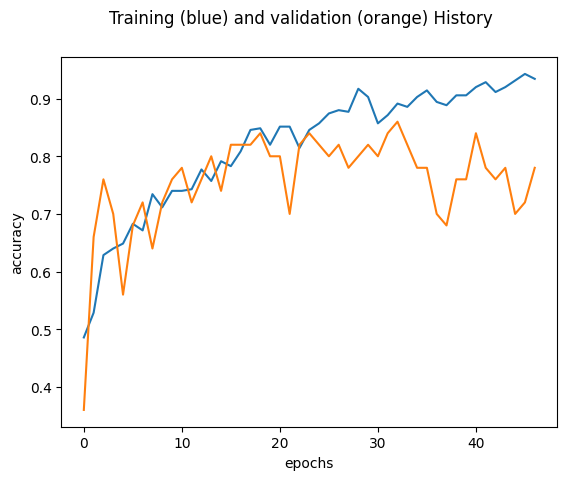

Test Accuracy 75.0%


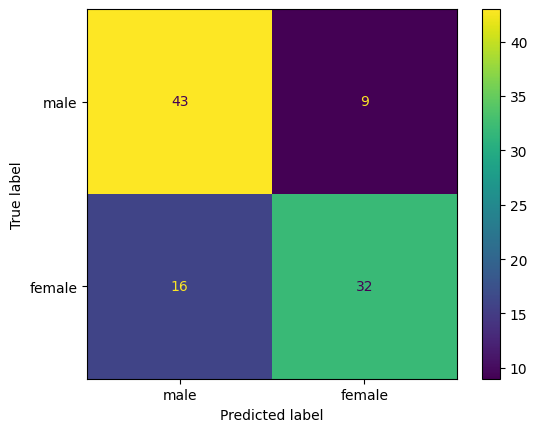

In [28]:
report(history,y_pred,y_true)

## You should see that now the training accuracy is actually often lower than the validation accuracy

- but both are steadily increasing
- you could change the patience value to leave it running longer
- (but on my machine it is using quite a lot of memory)

### The test accuracy is  11% higher than without augmentation - is this significant?

# Questions to investigate:
1. What is the effect of the random sampling even with no transformations?  
   Try setting all the options to False and do a few train/test runs
2. Which of these are valid and useful transformations for human faces?:
 - translation (horizontal/vertical) shifts
 - rotation
 - horizontal flips
 - vertical flips
 
Do you think it would  make a difference what the task is, i.e. gender recognition vs. recognising a specific person?
 
To do this investigation using appropriate scientific method, treat each of these as a hypothesis to be tested. Take a number of observations (e.g. accuracy of trained model) for each case (e.g. using horizontal flips vs not using horizontal flips) then compare the mean results and use appropriate statistcal tests to determine whether the results are statistically significantly different.

# The main task:

- Use the different pipeline components above to experiment with different sorts of data augmenation available within keras e.g. rotations, zoom,contrast changes,  and vertical/ horizontal flips. There are others available that only require a minor extension to my make_augmenter() function.
- Design an appropriate methodology to evaluate what difference they make singly or in combination to the classification accuracy of the trained system?  
  *Hint*: If you are making several changes to a system you need some way of knowing which have had an effect: [ilustrated in 200 words](https://thaddeus-segura.com/data-aug/)


## The second task:
In the basic method definition of a CNN we had batch normalisation and dropout turned off
Try changing the code to see what the effect o thee other approaches for reducing over-fitting are in combiation with the data augmentation

## The third task:
The approach I used above creates a set of keras layers and pre-processes the data **outside** the model.
 - it is **option 2** in [this blog](https://www.tensorflow.org/tutorials/images/data_augmentation)
 - the alternative is to make the augmentation (or other preprocessing layers) part of your model. 
   described as option 1 in the blog.

To give you more familiarity with working with keras layers, try adapting the convnet() method to put the data augemntation layers inside the model  and see:
- does it affect training speed
- does it affect predictive accuracy?

### class discussion
does data augmentation provide a away of addressing:
- ethical concerns about under-representation of certain groups
- safety concerns for example wrt autonomous vehicles

